<a href="https://colab.research.google.com/github/renecotyfanboy/JAXtronomy-tutorials/blob/main/nbody.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentiable DM simulations

Authors : Florian Saron,  Simon Dupourqué

## Imports

In [20]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!pip install --quiet cmasher

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [21]:
import jax
jax.config.update("jax_enable_x64", True)

import os
import moviepy.video.io.ImageSequenceClip
import jax.numpy as jnp
import jax_cosmo as jc
import jax.scipy as jsp
import optax
import time
import tqdm
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode
from jax.experimental.ode import odeint
from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn
from matplotlib.colors import LogNorm

## jaxPM

jaxPM is a JAX implementation of the N-body Particle-Mesh solver that solves the Poisson equation using FFTs. You can find the code here https://github.com/DifferentiableUniverseInitiative/JaxPM

The strength of this JAX version is 2 fold as we saw in the intro:
1.   It is differentiable, jitted, can run on GPU and in parallel at scale
2.   It benefits from the numpy-like syntax, making it easy to read for any python user


Long story short what JaxPM does is evolving initial gaussian conditions through cosmic time.


So first, let's generate some initital conditions that follow the linear matter power spectrum.

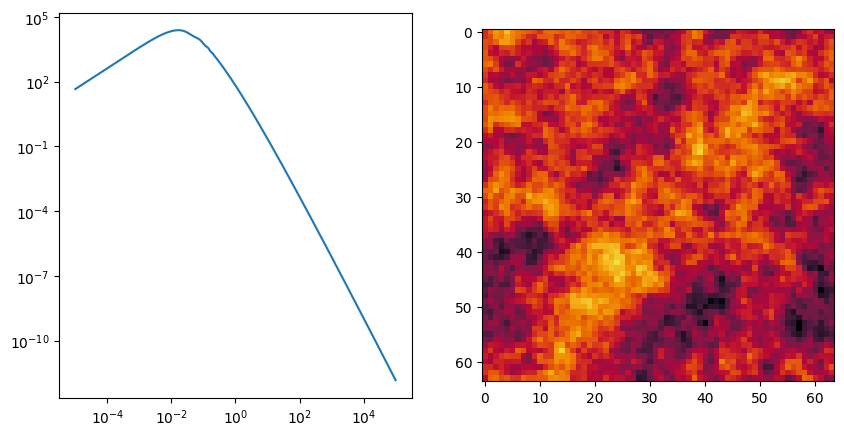

In [22]:
import cmasher as cmr

mesh_shape= [64, 64, 64] #number of mesh pixels/particules in x,y,z
box_size  = [20., 20., 20.] #comoving size of the box on Mpc/h
snapshots = jnp.linspace(0.1,1.,100) #scale factor (a) of snapshots to follow the redshift evolution
redshifts = 1/snapshots - 1. #redshifts of the snapshots

k = jnp.logspace(-5, 5, 512) #wave number vector to sample the matter power spectrum
cosmo = jc.Planck15() #set cosmology
pk = jc.power.linear_matter_power(cosmo, k) #get power spectrum

pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape) #make interpolation
linear = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(20)) #apply power spectrum to the 3d mesh/box to get a field realisation


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(k, pk) # plot 1D power spectrum
ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.imshow(linear[32:].sum(axis=0), cmap=cmr.ember) #plot 2D projection of linear field

## Forward model

Let's write the function that allows to go from initial conditions to final state of the N-body simulation and run it

In [23]:
mesh_shape= [64, 64, 64]
box_size  = [20., 20., 20.]
snapshots = jnp.linspace(0.1,1.,100)
redshifts = 1/snapshots - 1

def run_simulation(mesh_shape, box_size, snapshots):

    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-5, 5, 512)
    cosmo = jc.Planck15()
    pk = jc.power.linear_matter_power(cosmo, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(20))
    #initial_conditions = jax.random.normal(jax.random.PRNGKey(10), shape=mesh_shape)
    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15()
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)

    # Return the simulation volume at requested
    return res[0], initial_conditions

In [24]:
evolved_field, initial_conditions = None, None # Just to disable the annoying warnings
%time evolved_field, initial_conditions = run_simulation(mesh_shape, box_size, snapshots)

CPU times: user 8.65 s, sys: 353 ms, total: 9.01 s
Wall time: 11.2 s
CPU times: user 8.45 s, sys: 161 ms, total: 8.61 s
Wall time: 16 s


**Congratulations ! You have just run a $64^3$ particles N-body simulation**



The states of the simulation give us the position of the particles in mesh coordinates

In [25]:
evolved_field[-1], evolved_field[-1].shape

(Array([[-1.93287051,  2.36829444, -0.37587905],
        [-4.35254669,  2.00276108,  1.14627866],
        [-5.09040587,  1.11516131,  3.2738088 ],
        ...,
        [61.04172992, 67.38515481, 63.45930004],
        [61.66453999, 66.95459842, 63.77847656],
        [60.98390845, 66.77439283, 64.18563986]], dtype=float64),
 (262144, 3))

(Array([[-1.93287051,  2.36829444, -0.37587905],
        [-4.35254669,  2.00276108,  1.14627866],
        [-5.09040587,  1.11516131,  3.2738088 ],
        ...,
        [61.04172992, 67.38515481, 63.45930004],
        [61.66453999, 66.95459842, 63.77847656],
        [60.98390845, 66.77439283, 64.18563986]], dtype=float64),
 (262144, 3))

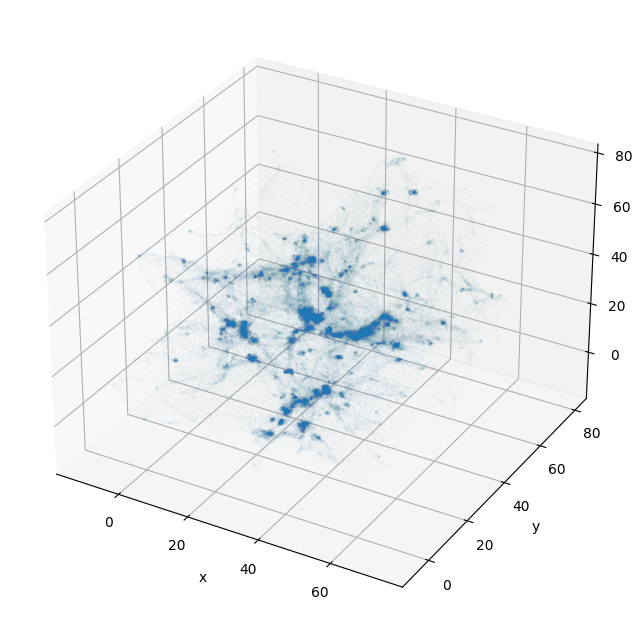

In [26]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='3d')
ax.scatter(
    evolved_field[-1, :, 0],
    evolved_field[-1, :, 1],
    evolved_field[-1, :, 2],
    s=0.0001
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Let's project this on the mesh grid using a cloud-in-cell (CIC) for each snapshot and make a movie

In [27]:
%matplotlib Agg

from tqdm.notebook import trange
painted_snapshots = []
img_norm = LogNorm(vmin=1e1, vmax=5e2)

for i in trange(len(snapshots)):
    painted_snapshots.append(cic_paint(jnp.zeros(mesh_shape), evolved_field[i])[:32].sum(axis=0))
    fig, ax = plt.subplots()
    im = ax.imshow(painted_snapshots[i], extent=[0,20,0,20], norm=img_norm, cmap=cmr.ember)
    ax.text(2,18, r'$z = $'+"{:2.2f}".format(redshifts[i]), color='white')
    ax.set_xlabel(r'$x~[{\rm Mpc} / h]$')
    ax.set_ylabel(r'$y~[{\rm Mpc} / h]$')
    plt.tight_layout()
    plt.savefig('snapshot_'+str(i)+'.png', dpi=100, transparent=False)
    plt.close()

fps=8
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(['snapshot_'+str(i)+'.png'
                                                             for i in range(len(snapshots))], fps=fps)
clip.write_videofile('simu_video.mp4')


mp4 = open('simu_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

  0%|          | 0/100 [00:00<?, ?it/s]

Moviepy - Building video simu_video.mp4.
Moviepy - Writing video simu_video.mp4



Moviepy - Done !
Moviepy - video ready simu_video.mp4


  0%|          | 0/100 [00:00<?, ?it/s]

Moviepy - Building video simu_video.mp4.
Moviepy - Writing video simu_video.mp4



Moviepy - Done !
Moviepy - video ready simu_video.mp4


## Initial value optimization

Now that we know how to run a simulation, we can take adavantage of the fact that all our operations to run it are differentiable thanks to JAX to solve efficiently an optimization problem (using the ADAM optimizer). Our optimization problem is : **Let's infer the cosmic evolution of large-scale strutures (LSS) from an observation at low redshift**. Let's use a smaller mesh shape for demonstration purposes (to accelerate things here). We generate a simulation amnd record the true inital and final state

In [28]:
mesh_shape= [16, 50, 50]
box_size  = [25.,50.,50.]
snapshots = jnp.linspace(0.1,1.,3)
redshifts = 1/snapshots - 1

evolved_field, initial_conditions = run_simulation(mesh_shape, box_size, snapshots)

true_final = cic_paint(jnp.zeros(mesh_shape), evolved_field[-1])

Let's consider the true_final as our data. We will look to reconstruct the initial conditions of the simulation by evolving them and comparing the final state the data. Let's define a loss function : mean square difference (MSE) between generated final state and data

In [29]:
@jax.jit
def evolve(initial_conditions):
    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15()
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    final_state = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)

    #Likelihood term of data
    final = cic_paint(jnp.zeros(mesh_shape), final_state[0][-1])
    return final


@jax.jit
def loss_fn(initial_conditions):
    loss = jnp.mean((evolve(initial_conditions) - true_final)**2)
    return loss

In [30]:
def fit(
    params: optax.Params,
    optimizer: optax.GradientTransformation
    ) -> optax.Params:

  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  losses = []
  params_save = []
  for i in (pbar := trange(nsteps)):
    params, opt_state, loss_value = step(params, opt_state)
    if i % 10 == 0:
      pbar.set_description(f"Loss : {loss_value}")
    losses.append(loss_value)
    params_save.append(params)

  return jnp.stack(losses), jnp.stack(params_save)

Let's run the optimization, starting with random rayleigh initial condition

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 0, 'step')

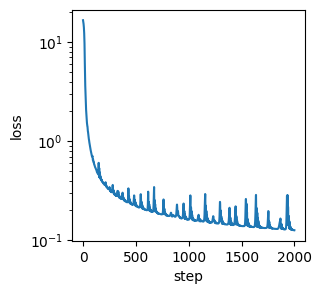

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
%matplotlib inline

rng = jax.random.PRNGKey(42)
params= jax.random.normal(rng, mesh_shape)**2
nsteps = 2000

optimizer = optax.adam(learning_rate=0.1)
losses, optim_params_array = fit(params, optimizer)

fig, ax = plt.subplots(figsize=(3,3))
ax.semilogy(losses)
ax.set_ylabel('loss')
ax.set_xlabel('step')

 Let's make a movie to see how our reconstruction was optimized

In [13]:
%matplotlib Agg
import numpy as np
from tqdm.notebook import tqdm
reconstructed_frames_final = []
reconstructed_frames_initial = []

indices2 = []
for i in np.arange(100, 1000, 100):
  indices2.append((i+losses[i:i+100].argmin()))
indices2 = np.array(indices2)

indices = np.append(np.append(np.arange(0, 50), 100), indices2)

for i, idx in enumerate(tqdm(indices)):

    reconstructed_frames_initial.append(optim_params_array[idx].sum(axis=0))
    reconstructed_frames_final.append(evolve(optim_params_array[idx]).sum(axis=0))

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
    ax = fig.add_subplot(111, frameon=False)
    img_norm = LogNorm(vmin=1e1, vmax=5e2)

    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    ax1.set_title("True init")
    ax1.imshow(
        initial_conditions.sum(axis=0),
        extent=[0, 50, 0, 50],
        norm=img_norm, cmap=cmr.ember
    )

    ax2.set_title("Best-fit init")
    ax2.imshow(
        reconstructed_frames_initial[i],
        extent=[0, 50, 0, 50],
        norm=img_norm, cmap=cmr.ember
    )

    ax3.set_title("True final")
    ax3.imshow(
        true_final.sum(axis=0),
        extent=[0,50,0,50],
        norm=img_norm,
        cmap=cmr.ember
    )

    ax4.set_title("Best-fit final")
    ax4.imshow(
        reconstructed_frames_final[i],
        extent=[0,50,0,50],
        norm=img_norm,
        cmap=cmr.ember
    )

    ax2.text(2,48, r'$i = $'+str(idx), color='white')
    ax4.text(2,48, r'$i = $'+str(idx), color='white')

    ax.set_xlabel(r'$x~[{\rm Mpc}~h^{-1}]$', fontsize=10)
    ax.set_ylabel(r'$y~[{\rm Mpc}~h^{-1}]$', fontsize=10)

    plt.tight_layout()

    plt.savefig('recon_'+str(idx)+'.png', dpi=100, transparent=False)
    plt.close()

fps=3
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(['recon_'+str(idx)+'.png'
                                                             for idx in indices], fps=fps)
clip.write_videofile('recon_video.mp4')

mp4 = open('recon_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

  0%|          | 0/60 [00:00<?, ?it/s]

Moviepy - Building video recon_video.mp4.
Moviepy - Writing video recon_video.mp4



Moviepy - Done !
Moviepy - video ready recon_video.mp4


# Bonus : JAX logo from dark matter simulations

In [14]:
!wget https://github.com/JAXtronomy/awesome-JAXtronomy/blob/f740c001ef4c51a3796afeff31f4233d7c2764cd/jaxtronomy_log.png?raw=true
!mv jaxtronomy_log.png?raw=true jaxtronomy_log.png

from PIL import Image
import numpy as np

# Load the image and ensure it's in RGBA mode
img = Image.open('jaxtronomy_log.png').convert('RGBA')
img = img.resize((50, 50))
data = np.array(img)
red, green, blue, alpha = data.T
gray = (0.299 * red + 0.587 * green + 0.114 * blue).astype(np.uint8)
gray[alpha == 0] = 0
gray_image = Image.fromarray(gray.T, mode='L')

los_extent = jnp.asarray([0]*4 + [1]*8 + [0]*4)[:, None, None]
los_extent = los_extent/los_extent.sum()
true_final = jnp.asarray(gray_image)[None, ...] * los_extent

rng = jax.random.PRNGKey(42)
params= jax.random.normal(rng, mesh_shape)**2
true_final = true_final/true_final.sum() * params.sum()

assert list(true_final.shape) == mesh_shape

--2024-10-15 18:33:21--  https://github.com/JAXtronomy/awesome-JAXtronomy/blob/f740c001ef4c51a3796afeff31f4233d7c2764cd/jaxtronomy_log.png?raw=true
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JAXtronomy/awesome-JAXtronomy/raw/f740c001ef4c51a3796afeff31f4233d7c2764cd/jaxtronomy_log.png [following]
--2024-10-15 18:33:21--  https://github.com/JAXtronomy/awesome-JAXtronomy/raw/f740c001ef4c51a3796afeff31f4233d7c2764cd/jaxtronomy_log.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JAXtronomy/awesome-JAXtronomy/f740c001ef4c51a3796afeff31f4233d7c2764cd/jaxtronomy_log.png [following]
--2024-10-15 18:33:21--  https://raw.githubusercontent.com/JAXtronomy/awesome-JAXtronomy/f740c001ef4c51a3796afeff31f4233d7c2764cd/jaxtronomy_log.png
Resolving raw.git

In [15]:
@jax.jit
def evolve(initial_conditions):
    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15()
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    final_state = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)

    #Likelihood term of data
    final = cic_paint(jnp.zeros(mesh_shape), final_state[0][-1])
    return final


@jax.jit
def loss_fn(initial_conditions):
    loss = jnp.mean((evolve(initial_conditions) - true_final)**2)
    return loss

In [16]:
def fit(
    params: optax.Params,
    optimizer: optax.GradientTransformation
    ) -> optax.Params:

  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  losses = []
  params_save = []
  for i in (pbar := trange(nsteps)):
    params, opt_state, loss_value = step(params, opt_state)
    if i % 10 == 0:
      pbar.set_description(f"Loss : {loss_value}")
    losses.append(loss_value)
    params_save.append(params)

  return jnp.stack(losses), jnp.stack(params_save)

In [17]:
@jax.jit
def evolve(initial_conditions):
    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15()
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)

    # Evolve the simulation forward
    final_state = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)

    #Likelihood term of data
    final = cic_paint(jnp.zeros(mesh_shape), final_state[0][-1])
    return final


@jax.jit
def loss_fn(initial_conditions):
    loss = jnp.mean((evolve(initial_conditions) - true_final)**2)
    return loss

def fit(
    params: optax.Params,
    optimizer: optax.GradientTransformation
    ) -> optax.Params:

  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state):
    loss_value, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  losses = []
  params_save = []
  for i in (pbar := trange(nsteps)):
    params, opt_state, loss_value = step(params, opt_state)
    if i % 10 == 0:
      pbar.set_description(f"Loss : {loss_value}")
    losses.append(loss_value)
    params_save.append(params)

  return jnp.stack(losses), jnp.stack(params_save)

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 0, 'step')

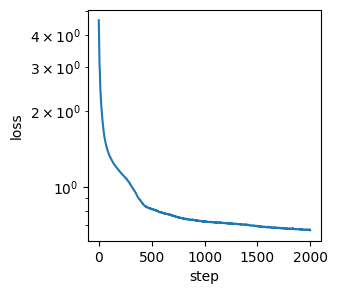

In [18]:
%matplotlib inline

nsteps = 2000

optimizer = optax.adam(learning_rate=0.1)
losses, optim_params_array = fit(params, optimizer)

fig, ax = plt.subplots(figsize=(3,3))
ax.semilogy(losses)
ax.set_ylabel('loss')
ax.set_xlabel('step')

In [19]:
%matplotlib Agg
import numpy as np
from tqdm.notebook import tqdm
reconstructed_frames_final = []
reconstructed_frames_initial = []

indices2 = []
for i in np.arange(100, 1000, 100):
  indices2.append((i+losses[i:i+100].argmin()))
indices2 = np.array(indices2)

indices = np.append(np.append(np.arange(0, 50), 100), indices2)

for i, idx in enumerate(tqdm(indices)):

    reconstructed_frames_initial.append(optim_params_array[idx].sum(axis=0))
    reconstructed_frames_final.append(evolve(optim_params_array[idx]).sum(axis=0))

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
    ax = fig.add_subplot(111, frameon=False)
    img_norm = LogNorm(vmin=1e1, vmax=5e2)

    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    ax1.set_title("True init")
    ax1.imshow(
        initial_conditions.sum(axis=0),
        extent=[0, 50, 0, 50],
        norm=img_norm, cmap=cmr.cosmic
    )

    ax2.set_title("Best-fit init")
    ax2.imshow(
        reconstructed_frames_initial[i],
        extent=[0, 50, 0, 50],
        norm=img_norm, cmap=cmr.cosmic
    )

    ax3.set_title("True final")
    ax3.imshow(
        true_final.sum(axis=0),
        extent=[0,50,0,50],
        norm=img_norm,
        cmap=cmr.cosmic
    )

    ax4.set_title("Best-fit final")
    ax4.imshow(
        reconstructed_frames_final[i],
        extent=[0,50,0,50],
        norm=img_norm,
        cmap=cmr.cosmic
    )

    ax2.text(2,48, r'$i = $'+str(idx), color='white')
    ax4.text(2,48, r'$i = $'+str(idx), color='white')

    ax.set_xlabel(r'$x~[{\rm Mpc}~h^{-1}]$', fontsize=10)
    ax.set_ylabel(r'$y~[{\rm Mpc}~h^{-1}]$', fontsize=10)

    plt.tight_layout()

    plt.savefig('recon_'+str(idx)+'.png', dpi=100, transparent=False)
    plt.close()

fps=3
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(['recon_'+str(idx)+'.png'
                                                             for idx in indices], fps=fps)
clip.write_videofile('recon_video.mp4')

mp4 = open('recon_video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

  0%|          | 0/60 [00:00<?, ?it/s]

Moviepy - Building video recon_video.mp4.
Moviepy - Writing video recon_video.mp4



Moviepy - Done !
Moviepy - video ready recon_video.mp4
